In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import pyro

In [4]:
import spaceoracle
from spaceoracle import SpaceOracle

In [5]:
import scanpy as sc
ad = sc.read_h5ad('../data/flowsig/adata_train_flowsig.h5ad')
ad

AnnData object with n_obs × n_vars = 10277 × 4998
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'spatial_kmeans'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'commot-user_database-info', 'flowsig_network', 'hvg', 'log1p', 'nsf_info', 'rctd_cluster_colors'
    obsm: 'X_flow', 'X_gem', 'X_spatial', 'commot-user_database-sum-receiver', 'commot-user_database-sum-sender', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'commot-user_database-Angptl2-Pirb', 'commot-user_database-Angptl4-Cdh5

In [6]:
from spaceoracle.tools.ligrec_network import LigandReceptorNetwork
ligrec_net = LigandReceptorNetwork(ad)
# ligrec_net.gl_dict

In [7]:
# target_gene = 'Il22ra2'
target_gene = 'Ccl5'
# target_gene = 'Cd74'
target_gene in ad.var_names

True

In [32]:
from spaceoracle.models.probabilistic_estimators import ProbabilisticPixelAttentionLR
pyro.clear_param_store()

estimator = ProbabilisticPixelAttentionLR(
    ad, lrn=ligrec_net, target_gene=target_gene, layer='imputed_count', annot='rctd_cluster')

/ix/djishnu/alw399/SpaceOracle/notebooks/../src/spaceoracle/models/estimators.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.lr['pairs'] = self.lr.ligand.values + '-' + self.lr.receptor.values


In [ ]:
%%time

# to do: 
# beta0 for receptor betas
# allow max radius as hyperparam
# freeze receptorNNs with .eval()

estimator.fit(
    annot='rctd_cluster', 
    max_epochs=10, 
    learning_rate=7e-4, 
    spatial_dim=32,
    batch_size=512,
    alpha=0.1,
    cache=False
)

In [10]:
y_trues, y_preds = estimator.get_preds()
len(y_trues), len(y_preds)

🌍️ Generating spatial 32x32 maps...


(10277, 10277)

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


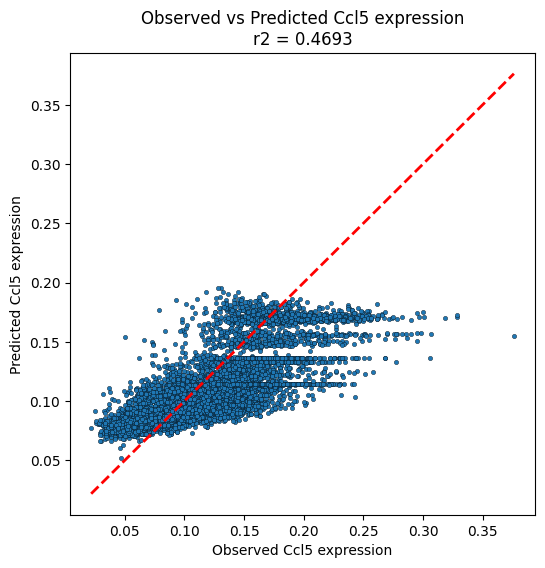

In [11]:
from sklearn.metrics import r2_score

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100

sns.scatterplot(
    x=y_trues, 
    y=y_preds, s=10, 
    cmap='tab10', 
    edgecolor='black', linewidth=0.25)

plt.xlabel(f'Observed {target_gene} expression')
plt.ylabel(f'Predicted {target_gene} expression')
plt.title(f'Observed vs Predicted {target_gene} expression\n'
    f'r2 = {r2_score(y_trues.reshape(-1), y_preds.reshape(-1)):.4f}')
# plt.xlim(y_trues.min()-0.25, y_trues.max()+0.25)
# plt.ylim(y_trues.min()-0.25, y_trues.max()+0.25)
# Add x=y line
plt.plot([y_trues.min(), y_trues.max()], [y_trues.min(), y_trues.max()], 'r--', lw=2)
plt.show()

In [14]:
tf_betas, rec_betas = estimator.get_betas()
tf_betas.shape, rec_betas.shape
# (cell, tf), (cell, receptor)

🌍️ Generating spatial 32x32 maps...


(torch.Size([10277, 34]), torch.Size([10277, 8]))

In [13]:
len(estimator.receptors), estimator.receptors

(8, ['Ackr3', 'Cd36', 'Cd44', 'Cdh5', 'Cxcr4', 'Sdc2', 'Sdc4', 'Tnfrsf13c'])